# Deep Learning Course

## Assignment Four 


### Assignment Goals:

* Implementing Fully Connected AutoEncoders

* Implement naive generative model

* Understand VAE and GAN, then implement a classical generative model: VAE-GAN. 



### DataSet

In this Assignment, you will use the Fashion-MNIST dataset. The dataset is not given in the assignment package, please download/load by yourself. *Hint*: You can use  
```python
(x_train, _), (x_test, _)  = keras.datasets.fashion_mnist.load_data() 
```
to load the dataset.


### Requirements


1. **(20 points) Implement a Fully Connected AutoEncoder** 

    * Your AutoEncoder should have a bottleneck with two neurons and use Mean Squared Error (MSE) as the objective function. Design the model structure by yourself. Notice that in an AutoEncoder, the layer with the least number of neurons is referred to as a bottleneck. 

    * Train your model on Fashion-MNIST. Plot the train and test loss. 

    * Randomly select 10 images from the test set, encode the selected 10 images, visualize the original images and the decoded images.


2. **(30 points) Naive generative model**

    This question is about using an AutoEncoder to generate similar but not identical Fashion-MNIST items. We use a naive approach: Try to see if a trained decoder can map randomly generated inputs (random numbers) to a recognizable Fashion-MNIST item. 
    
    1. Start with your Fully Connected AutoEncoder from part 1. Try to generate new images by inputting some random numbers to the decoder (i.e. the bottleneck layer). Visualize 10 generated images. (10 points)
    
    2. Now restrict each neuron of the bottleneck layer to have a distribution with mean zeroes and variance one (i.e. $N(0, 1)$). Retrain the Fully Connected AutoEncoder with the normalized bottleneck. Now randomly generate inputs to the bottleneck layer that are drawn from the multi-variate standard normal distribution, and use the randomly generated inputs to generate new images. Visualize 10 generated images. (15 points)
    
    3. Are the output images different between A) and B)? If so, why do you think this difference occurs? (5 points)


3. **(50 points + 5 points BONUS(optional)) Advanced generative model**

    In this part, you are asking to implement a VAE-GAN model. A VAE-GAN is a Generative Adversarial Network whose generator is an Variational Autoencoder.Here is the paper which proposed the VAE-GAN: [**[PAPER]**](https://arxiv.org/pdf/1512.09300.pdf ). You may need to read this paper before implementing this model. 

    1. Implement a Variational Autoencoder based on your Fully Connected AutoEncoder from part 1. Use your VAE to randomly generate 10 images. Does the VAE produce a different quality of output image? (30 points)

    2. Implement a VAE-GAN based on your implemented VAE. Train the VAE-GAN. (20 points)
      * Then use your VAE-GAN to randomly generate 10 images from $p(z)$. 
      * Randomly select 10 images from the test dataset and reconstruct them using your model, then visualize the original and reconstructed images. 
      * **Loss-function of your VAE-GAN model:**
          * The basic assignment will choose the $L_{prior}$ and $L_{Gan}$ loss described in the paper (Eq. 5). So your loss function will be 
          
          $L = L_{prior} + L_{gan}$
          
          instead of $L = L_{prior} + L^{Dis_l} + L_{gan}$ (Eq. 8).
          
      * **BONUS(5 points)**: For those of you who already incorporated the $L^{dis_l}$ term, or want to try it, this would be a bonus question. The basic idea here is to use a discriminator and use one of the hidden layers in the discriminator as a representation of the input. They apply this with a CNN but you can use a hidden discriminator layer with different discriminator architectures. You would be free to use your own creativity in how to select a discriminator layer.
      
      * *Hint: (1) For the generation and reconstruction tasks, refer to Section 4.1 in the paper.(2) the authors have posted their code in Github. You should write your own code completely from scratch, but you can look at their code as a resource for clarification.*



### Submission Notes:

Please use Jupyter Notebook. The notebook should include the final code, results, and answers. You should submit your Notebook in .pdf and .ipynb format. (penalty 10 points).

Notice that your AutoEncoders should have only one bottleneck.


**Instructions**:

The university policy on academic dishonesty and plagiarism (cheating) will be taken very seriously in this course. Everything submitted should be your writing or coding. You must not let other students copy your work. Spelling and grammar count.





## Your implementation

In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [ ]:
# import tensorflow as tf
# # use GPU
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
# raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# colab_path = '/content/gdrive/MyDrive/'

In [31]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)

print(tf.__version__)

2.4.1


Dataset Preprocessing and Visualization

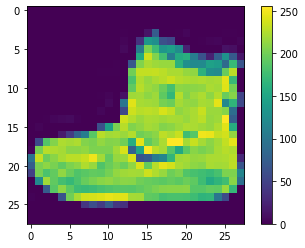

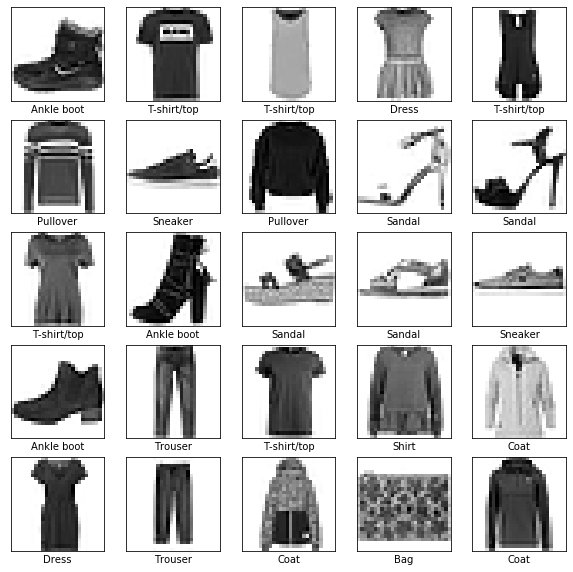

In [32]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

# data preprocessing
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# visualize 25 data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

### 1. Implement a Fully Connected AutoEncoder

* Your AutoEncoder should have a bottleneck with two neurons and use Mean Squared Error (MSE) as the objective function. Design the model structure by yourself. Notice that in an AutoEncoder, the layer with the least number of neurons is referred to as a bottleneck. 

* Train your model on Fashion-MNIST. Plot the train and test loss. 

* Randomly select 10 images from the test set, encode the selected 10 images, visualize the original images and the decoded images.

In [33]:
encoding_dim = 2
input_img = keras.Input(shape=(784,))

# encoder
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
    
# decoder
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 1570      
_________________________________________________________________
dense_19 (Dense)             (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


In [4]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# training 
history = autoencoder.fit(x_train, x_train,
                          epochs=15,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(x_test, x_test)) 

Epoch 1/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0823 - val_loss: 0.0577
Epoch 2/15
1875/1875 [==============================] - 1s 744us/step - loss: 0.0562 - val_loss: 0.0506
Epoch 3/15
1875/1875 [==============================] - 1s 764us/step - loss: 0.0495 - val_loss: 0.0462
Epoch 4/15
1875/1875 [==============================] - 1s 793us/step - loss: 0.0456 - val_loss: 0.0446
Epoch 5/15
1875/1875 [==============================] - 2s 838us/step - loss: 0.0445 - val_loss: 0.0443
Epoch 6/15
1875/1875 [==============================] - 2s 832us/step - loss: 0.0443 - val_loss: 0.0442
Epoch 7/15
1875/1875 [==============================] - 2s 815us/step - loss: 0.0443 - val_loss: 0.0441
Epoch 8/15
1875/1875 [==============================] - 1s 789us/step - loss: 0.0442 - val_loss: 0.0441
Epoch 9/15
1875/1875 [==============================] - 1s 760us/step - loss: 0.0443 - val_loss: 0.0441
Epoch 10/15
1875/1875 [==============================] - 1s 754us/

Visualize train and test loss:

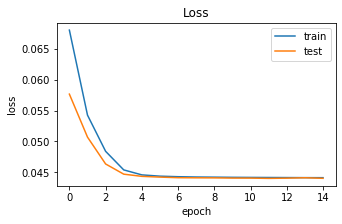

In [110]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

Randomly select 10 images from the test set, encode the selected 10 images, visualize the original images and the decoded images.

(10000, 2)
(10000, 784)


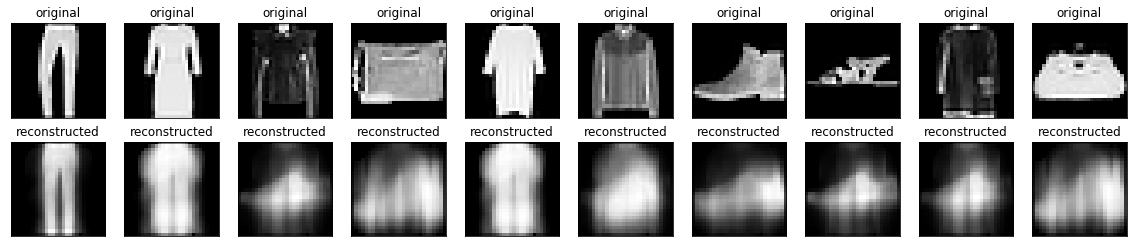

In [5]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# 10 random images
random.seed(0)
n = 10
random_list = random.sample(range(1, x_test.shape[0]), n)

plt.figure(figsize=(20, 4))
for i, i_img in enumerate(random_list):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i_img].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i_img].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 2. Naive generative model

This question is about using an AutoEncoder to generate similar but not identical Fashion-MNIST items. We use a naive approach: Try to see if a trained decoder can map randomly generated inputs (random numbers) to a recognizable Fashion-MNIST item. 
    
1. Start with your Fully Connected AutoEncoder from part 1. Try to generate new images by inputting some random numbers to the decoder (i.e. the bottleneck layer). Visualize 10 generated images. (10 points)

(10, 2)


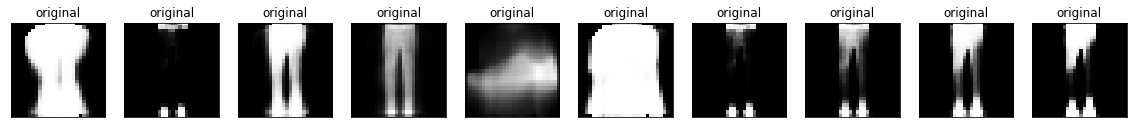

In [20]:
import sys

n = 10
rand_x = np.random.uniform(0, sys.maxsize, n)
rand_y = np.random.uniform(0, sys.maxsize, n)

rand_x = np.random.uniform(0, 100, n)
rand_y = np.random.uniform(0, 100, n)

encoded_imgs = np.vstack((rand_x, rand_y)).T
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
#     plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

2. Now restrict each neuron of the bottleneck layer to have a distribution with mean zeroes and variance one (i.e. $N(0, 1)$). Retrain the Fully Connected AutoEncoder with the normalized bottleneck. Now randomly generate inputs to the bottleneck layer that are drawn from the multi-variate standard normal distribution, and use the randomly generated inputs to generate new images. Visualize 10 generated images.

In [34]:
encoding_dim = 2
input_img = keras.Input(shape=(784,))

# encoder
encoded_h = layers.Dense(encoding_dim, activation='relu')(input_img)
encoded = layers.BatchNormalization()(encoded_h)
    
# decoder
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 1570      
_________________________________________________________________
batch_normalization (BatchNo (None, 2)                 8         
_________________________________________________________________
dense_21 (Dense)             (None, 784)               2352      
Total params: 3,930
Trainable params: 3,926
Non-trainable params: 4
_________________________________________________________________


In [31]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# training 
history = autoencoder.fit(x_train, x_train,
                          epochs=25,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(x_test, x_test)) 

Epoch 1/25
1875/1875 [==============================] - 2s 980us/step - loss: 0.1114 - val_loss: 0.0625
Epoch 2/25
1875/1875 [==============================] - 2s 851us/step - loss: 0.0629 - val_loss: 0.0613
Epoch 3/25
1875/1875 [==============================] - 2s 844us/step - loss: 0.0626 - val_loss: 0.0612
Epoch 4/25
1875/1875 [==============================] - 2s 840us/step - loss: 0.0624 - val_loss: 0.0612
Epoch 5/25
1875/1875 [==============================] - 2s 851us/step - loss: 0.0625 - val_loss: 0.0612
Epoch 6/25
1875/1875 [==============================] - 2s 841us/step - loss: 0.0624 - val_loss: 0.0620
Epoch 7/25
1875/1875 [==============================] - 2s 854us/step - loss: 0.0626 - val_loss: 0.0612
Epoch 8/25
1875/1875 [==============================] - 2s 857us/step - loss: 0.0625 - val_loss: 0.0620
Epoch 9/25
1875/1875 [==============================] - 2s 842us/step - loss: 0.0627 - val_loss: 0.0613
Epoch 10/25
1875/1875 [==============================] - 2s 846u

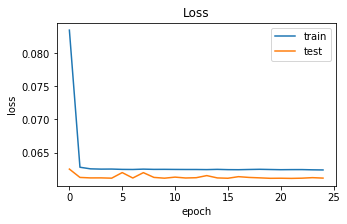

In [32]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

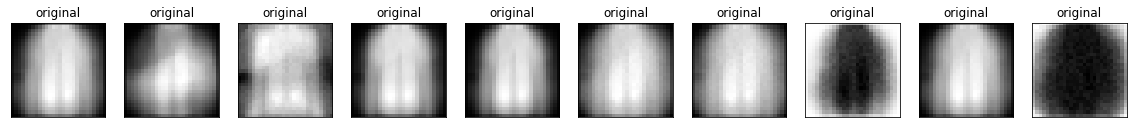

In [38]:
n = 10

mu, sigma = 0, 1 # mean and standard deviation

rand_x = np.random.normal(mu, sigma, n)
rand_y = np.random.normal(mu, sigma, n)

encoded_imgs = np.vstack((rand_x, rand_y)).T
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure(figsize=(20, 2))
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

3. Are the output images different between A) and B)? If so, why do you think this difference occurs?

Yes, the output images in part B are better and more similar to our dataset. Because the inputs that randomly generated from the standard distribution are more similar to encoded inputs of the decoder in training since we forced to be normal distribution by adding normalization layer.

### 3. Advanced generative model

In this part, you are asking to implement a VAE-GAN model. A VAE-GAN is a Generative Adversarial Network whose generator is an Variational Autoencoder.Here is the paper which proposed the VAE-GAN: [**[PAPER]**](https://arxiv.org/pdf/1512.09300.pdf ). You may need to read this paper before implementing this model. 

1. Implement a Variational Autoencoder based on your Fully Connected AutoEncoder from part 1. Use your VAE to randomly generate 10 images. Does the VAE produce a different quality of output image? (30 points)
The images somehow similar to our dataset but they are blurry.

In [35]:
# I used sample code here: https://keras.io/examples/generative/vae/ and changed that for this question.

# sampling layer
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2

# encoder  
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(2, activation="relu")(x) # 16
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

print("__________________________________________________________________________________________________")
# decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(784, activation="relu")(latent_inputs)
decoder_outputs = layers.Reshape((28, 28, 1))(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 784)          0           input_32[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 2)            1570        flatten_9[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            6           dense_22[0][0]                   
____________________________________________________________________________________________

In [36]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [37]:
x_train = x_train.reshape((len(x_train), 28, 28))
x_test = x_test.reshape((len(x_test), 28, 28))

dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32")

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# training
history_vae = vae.fit(dataset,
                      epochs=30,
                      batch_size=128)

Epoch 1/30
547/547 [==============================] - 2s 2ms/step - loss: 1136.0357 - reconstruction_loss: 731.4400 - kl_loss: 8.6596
Epoch 2/30
547/547 [==============================] - 1s 2ms/step - loss: 408.7681 - reconstruction_loss: 381.1529 - kl_loss: 10.2228
Epoch 3/30
547/547 [==============================] - 2s 3ms/step - loss: 366.0659 - reconstruction_loss: 354.3633 - kl_loss: 9.8887
Epoch 4/30
547/547 [==============================] - 1s 2ms/step - loss: 357.8095 - reconstruction_loss: 344.7169 - kl_loss: 10.0206
Epoch 5/30
547/547 [==============================] - 1s 2ms/step - loss: 339.0248 - reconstruction_loss: 325.6402 - kl_loss: 11.2093
Epoch 6/30
547/547 [==============================] - 1s 2ms/step - loss: 330.6639 - reconstruction_loss: 317.0673 - kl_loss: 11.6512
Epoch 7/30
547/547 [==============================] - 2s 3ms/step - loss: 330.2537 - reconstruction_loss: 314.6755 - kl_loss: 11.5739
Epoch 8/30
547/547 [==============================] - 1s 3ms/st

Use your VAE to randomly generate 10 images:

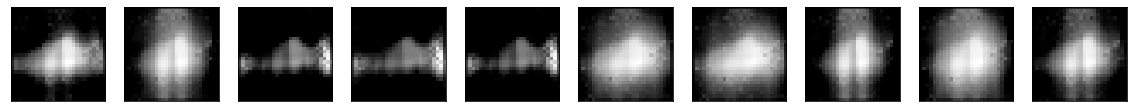

In [38]:
def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    img_size = 28
    scale = 1.0
    figure = np.zeros((img_size, img_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    rand_x = np.random.uniform(-1.0, 1.0, n)
    rand_y = np.random.uniform(-1.0, 1.0, n)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        xi = rand_x[i]
        yi = rand_y[i]
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size)
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()
    
plot_latent_space(vae)

2. Implement a VAE-GAN based on your implemented VAE. Train the VAE-GAN. (20 points)
    * Then use your VAE-GAN to randomly generate 10 images from $p(z)$. 
    * Randomly select 10 images from the test dataset and reconstruct them using your model, then visualize the original and reconstructed images. 
    * **Loss-function of your VAE-GAN model:**
        * The basic assignment will choose the $L_{prior}$ and $L_{Gan}$ loss described in the paper (Eq. 5). So your loss function will be 

         $L = L_{prior} + L_{gan}$

         instead of $L = L_{prior} + L^{Dis_l} + L_{gan}$ (Eq. 8).

    * **BONUS(5 points)**: For those of you who already incorporated the $L^{dis_l}$ term, or want to try it, this would be a bonus question. The basic idea here is to use a discriminator and use one of the hidden layers in the discriminator as a representation of the input. They apply this with a CNN but you can use a hidden discriminator layer with different discriminator architectures. You would be free to use your own creativity in how to select a discriminator layer.

    * *Hint: (1) For the generation and reconstruction tasks, refer to Section 4.1 in the paper.(2) the authors have posted their code in Github. You should write your own code completely from scratch, but you can look at their code as a resource for clarification.*

In [8]:
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Reshape, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import tensorflow as tf

In [9]:
# based on # https://zhuanlan.zhihu.com/p/104049963 
class VAE:
    def __init__(self, input_shape, intermediate_dim=784, latent_dim=2):
        def sampling(args):
            """  Sampling z.  """
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        # Encoder
        self.inputs = Input(shape=input_shape)
        self.inputs = Input(shape=input_shape)
        x = Flatten()(self.inputs)
        x = Dense(2, activation="relu")(x) # 16
        z_mean = Dense(latent_dim, name="z_mean")(x)
        z_log_var = Dense(latent_dim, name="z_log_var")(x)
        z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
        self.encoder = Model(self.inputs, [z_mean, z_log_var, z], name='encoder')
        self.encoder.summary()
    

        # Decoder
        latent_inputs = Input(shape=(latent_dim,))
        x = Dense(784, activation="relu")(latent_inputs)
        decoded = Reshape((28, 28, 1))(x)
        self.decoder = Model(latent_inputs, decoded, name='decoder')
        self.decoder.summary()

        # VAE
        self.outputs = self.decoder(self.encoder(self.inputs)[2])
        self.vae = Model(self.inputs, self.outputs, name='vae_convo')

        def vae_loss(y_true, y_pred):
            def mean_squared_error(y_t, y_p):
                return K.mean(K.sum(K.square(y_p - y_t), axis=[-3,-2,-1]))
            reconstruction_loss = mean_squared_error(y_true, y_pred)
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.mean(K.sum(kl_loss, axis=-1))
            kl_loss *= -0.5
            return reconstruction_loss + kl_loss/latent_dim

        self.vae.compile(optimizer='adam', loss=vae_loss, metrics=['mae'])
        self.vae.summary()

    def train(self, x, batch_size=32, epochs=10, val_ratio=0.1):
        self.vae.fit(x, x, epochs=epochs, batch_size=batch_size, validation_split=val_ratio, shuffle=True)
        return self.vae, self.encoder, self.decoder

In [14]:
def discriminator_model(In_Shape, name='discriminator'):
    inputs = Input(shape=In_Shape, name='Normal_inputs')
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', name='C1')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', name='C2')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2,2), name='MP1')(x)
    x = Dropout(0.2, name='Drop1')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='C3')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='C4')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2,2), name='MP2')(x)
    x = Dropout(0.2, name='Drop2')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='C5')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', name='C6')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D(pool_size=(2,2), name='MP3')(x)
    x = Dropout(0.2, name='Drop3')(x)
    x = Flatten(name='Flatten')(x)
    x = Dense(512, name='D1')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2, name='Drop4')(x)
    x = Dense(1, name='logits')(x)
    outputs = Activation('sigmoid', name='normal_output')(x)
    model = Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [29]:
class VAEGAN:
    def __init__(self, in_shape, z_shape, encoder, decoder, discriminator, inter_layer_ind, gamma=1):
        self.z_shape = (z_shape,)
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

        self.intermediate_discriminator = Model(inputs=self.discriminator.inputs,
                                                    outputs=self.discriminator.layers[inter_layer_ind].output,
                                                    name='intermediate_discriminator')
        self.intermediate_discriminator.trainable = False
        self.intermediate_discriminator.compile(loss='binary_crossentropy', optimizer='adam')

        
        vae_input = Input(shape=in_shape, name='vae_input')
        z_mean_x, z_log_var_x, z_x = self.encoder(vae_input)
        vae_output = self.decoder(z_x)
        self.vae = Model(inputs=vae_input, outputs=vae_output, name='vae')

        random_z = Input(shape=self.z_shape, name='random_z')
        random_generated = self.decoder(random_z)

        real_img = Input(shape=in_shape, name='real_img')

        real_score = self.discriminator(real_img)
        tiled_score = self.discriminator(vae_output)
        random_score = self.discriminator(random_generated)

        real_l = self.intermediate_discriminator(real_img)
        tiled_l = self.intermediate_discriminator(vae_output)

        # prior loss
        kl_loss = 1 + z_log_var_x - K.square(z_mean_x) - K.exp(z_log_var_x)
        kl_loss = K.mean(K.sum(kl_loss, axis=-1))
        kl_loss *= -0.5
        prior_loss = kl_loss/z_shape
        rec_loss = K.mean(K.mean(K.square(vae_output - vae_input), axis=[-3,-2,-1]))

        # Dis-l loss
        dis_loss = K.mean(K.square(real_l-tiled_l))

        # GAN loss
        encoder_loss = prior_loss + dis_loss
        generator_loss = K.mean(K.relu(1-tiled_score) + K.relu(1-random_score)) + gamma * dis_loss
        discriminator_loss = K.mean(K.relu(1-real_score) + K.relu(tiled_score) + K.relu(random_score))

        self.encoder_to_train = Model(inputs=[vae_input, real_img, random_z], outputs=[tiled_score, random_score, real_l, tiled_l], name='encoder_to_train')
        self.decoder_to_train = Model(inputs=[vae_input, real_img, random_z], outputs=[tiled_score, random_score, real_l, tiled_l], name='decoder_to_train')
        self.discriminator_to_train = Model(inputs=[vae_input, real_img, random_z], outputs=[tiled_score, real_score, random_score], name='discriminator_to_train')

        self.encoder_to_train.add_loss(encoder_loss)
        self.decoder_to_train.add_loss(generator_loss)
        self.discriminator_to_train.add_loss(discriminator_loss)

        self.encoder_to_train.get_layer('discriminator').trainable = False
        self.encoder_to_train.get_layer('decoder').trainable = False
        self.encoder_to_train.get_layer('encoder').trainable = True
        self.encoder_to_train.compile(optimizer=Adam(0.0002, 0.5))

        self.decoder_to_train.get_layer('encoder').trainable = False
        self.decoder_to_train.get_layer('discriminator').trainable = False
        self.decoder_to_train.get_layer('decoder').trainable = True
        self.decoder_to_train.compile(optimizer=Adam(0.0002, 0.5))

        self.discriminator_to_train.get_layer('encoder').trainable = False
        self.discriminator_to_train.get_layer('decoder').trainable = False
        self.discriminator_to_train.get_layer('discriminator').trainable = True
        self.discriminator_to_train.compile(optimizer=Adam(0.0001, 0.5))

        self.encoder_to_train.summary()
        self.decoder_to_train.summary()
        self.discriminator_to_train.summary()

    def train(self, train_x, real_x, batch_size, epochs):
        history = LossHistory()
        batch_num = int(train_x.shape[0]/batch_size)
        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}:')

            for batch in range(batch_num):
                # print(batch, "/", batch_num)
                rand_inds = np.random.randint(0, real_x.shape[0], batch_size)
                train_x_batch = train_x[rand_inds]
                real_x_batch = real_x[rand_inds]
                random_z_batch = np.random.normal(0, 1, (batch_size, self.z_shape[0]))

                self.discriminator_to_train.fit([train_x_batch, real_x_batch, random_z_batch], batch_size=batch_size,
                                epochs=1, validation_split=0, verbose=0, callbacks=[history])
                if batch%100 == 0:
                # if batch == batch_num - 1:
                    print(f'Discriminator loss: {history.losses}')

                self.encoder_to_train.fit([train_x_batch, real_x_batch, random_z_batch], batch_size=batch_size,
                              epochs=1, validation_split=0, verbose=0, callbacks=[history])
                if batch%100 == 0:
                # if batch == batch_num - 1:
                    print(f'Encoder loss: {history.losses}')

                self.decoder_to_train.fit([train_x_batch, real_x_batch, random_z_batch], batch_size=batch_size,
                              epochs=1, validation_split=0, verbose=0, callbacks=[history])
                if batch%100 == 0:
                # if batch == batch_num - 1:
                    print(f'Decoder losses: {history.losses}')
                    print("\n")
                    
        # Visualization:
        input_imgs = train_x[np.random.randint(0, train_x.shape[0], 10)]
        rec_input_imgs = self.decoder.predict(self.encoder.predict(input_imgs)[2])
        random_noises = np.random.normal(0, 1, (10, self.z_shape[0]))
        rec_random_noises = self.decoder.predict(random_noises)

        fig, axes = plt.subplots(nrows=3, ncols=10)
        for c in range(10):
            input_imgs1 = input_imgs[:, :, :, 0]
            rec_input_imgs1 = rec_input_imgs[:, :, :, 0]
            rec_random_noises1 = rec_random_noises[:, :, :, 0]

            axes[0][c].imshow((input_imgs1[c]+1)/2)
            axes[1][c].imshow((rec_input_imgs1[c]+1)/2)
            axes[2][c].imshow((rec_random_noises1[c]+1)/2)

        plt.show()
        return self.encoder, self.decoder, self.discriminator

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 784)          0           input_26[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 2)            1570        flatten_8[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            6           dense_16[0][0]                   
____________________________________________________________________________________________

Discriminator loss: [1.492020606994629]
Encoder loss: [0.3903355002403259]
Decoder losses: [0.9963109493255615]


Discriminator loss: [0.000952103000599891]
Encoder loss: [1.1110262870788574]
Decoder losses: [3.1062536239624023]


Discriminator loss: [0.0002642489271238446]
Encoder loss: [1.6948623657226562]
Decoder losses: [3.6907107830047607]


Discriminator loss: [0.00010092339653056115]
Encoder loss: [1.7156788110733032]
Decoder losses: [3.707120895385742]


Discriminator loss: [7.323936733882874e-05]
Encoder loss: [1.6886975765228271]
Decoder losses: [3.6739039421081543]


Discriminator loss: [3.810795897152275e-05]
Encoder loss: [1.7431235313415527]
Decoder losses: [3.7416317462921143]


Discriminator loss: [2.5860097593977116e-05]
Encoder loss: [1.7811338901519775]
Decoder losses: [3.811282157897949]


Discriminator loss: [1.794377385522239e-05]
Encoder loss: [1.7058695554733276]
Decoder losses: [3.6990535259246826]


Discriminator loss: [1.1829029972432181e-05]
Encoder loss: [2

Decoder losses: [3.0248544216156006]


Discriminator loss: [6.647343120391724e-09]
Encoder loss: [1.0301129817962646]
Decoder losses: [3.0593278408050537]


Discriminator loss: [6.246119621522439e-09]
Encoder loss: [1.0080370903015137]
Decoder losses: [3.0096826553344727]


Discriminator loss: [3.6899927557954015e-09]
Encoder loss: [0.9215437173843384]
Decoder losses: [2.9243619441986084]


Discriminator loss: [1.6573176164769166e-09]
Encoder loss: [1.0811870098114014]
Decoder losses: [3.0909273624420166]


Discriminator loss: [1.1697330215554302e-08]
Encoder loss: [1.1238834857940674]
Decoder losses: [3.122072219848633]


Discriminator loss: [1.6253243195762934e-09]
Encoder loss: [1.0945006608963013]
Decoder losses: [3.026371955871582]


Epoch 5/15:
Discriminator loss: [1.0948919992870287e-08]
Encoder loss: [0.952969491481781]
Decoder losses: [2.931337356567383]


Discriminator loss: [1.1840874947210978e-09]
Encoder loss: [0.9866340160369873]
Decoder losses: [2.999164581298828]


Disc

Decoder losses: [4.151370048522949]


Discriminator loss: [4.5823211891615756e-10]
Encoder loss: [2.025953531265259]
Decoder losses: [4.043831825256348]


Discriminator loss: [5.7184094265361196e-11]
Encoder loss: [2.326406955718994]
Decoder losses: [4.332185745239258]


Discriminator loss: [3.549850691175749e-10]
Encoder loss: [2.0902843475341797]
Decoder losses: [4.068285942077637]


Discriminator loss: [5.78837255904574e-11]
Encoder loss: [2.2310409545898438]
Decoder losses: [4.203954696655273]


Discriminator loss: [2.595534065452654e-10]
Encoder loss: [1.9029271602630615]
Decoder losses: [3.8724656105041504]


Discriminator loss: [6.153697690303161e-11]
Encoder loss: [2.1935741901397705]
Decoder losses: [4.168499946594238]


Discriminator loss: [1.3316575619981563e-10]
Encoder loss: [1.977990984916687]
Decoder losses: [3.909787654876709]


Discriminator loss: [1.0172841735656135e-10]
Encoder loss: [2.143920421600342]
Decoder losses: [4.155622482299805]


Discriminator loss: [3.083

Decoder losses: [4.6287126541137695]


Discriminator loss: [3.01482451682753e-17]
Encoder loss: [2.4056124687194824]
Decoder losses: [4.450058937072754]


Discriminator loss: [1.8287396597038708e-10]
Encoder loss: [2.9926276206970215]
Decoder losses: [4.899579048156738]


Discriminator loss: [8.659523619003462e-12]
Encoder loss: [3.0653388500213623]
Decoder losses: [4.977266788482666]


Discriminator loss: [3.724595076803894e-10]
Encoder loss: [2.7689096927642822]
Decoder losses: [4.699635028839111]


Discriminator loss: [2.5220502769540687e-11]
Encoder loss: [3.276996612548828]
Decoder losses: [5.249348163604736]


Discriminator loss: [7.93379736907518e-11]
Encoder loss: [2.8683156967163086]
Decoder losses: [4.818343639373779]


Discriminator loss: [7.969562509924089e-12]
Encoder loss: [2.9564507007598877]
Decoder losses: [4.935966491699219]


Discriminator loss: [3.484852337254374e-11]
Encoder loss: [3.5698835849761963]
Decoder losses: [5.535994529724121]


Discriminator loss: [5.791

Decoder losses: [5.2090349197387695]


Discriminator loss: [1.7640256659914866e-13]
Encoder loss: [3.156921625137329]
Decoder losses: [5.160468101501465]


Discriminator loss: [3.80402350244613e-12]
Encoder loss: [2.9058549404144287]
Decoder losses: [4.881590843200684]


Discriminator loss: [4.610506380430153e-14]
Encoder loss: [2.930476665496826]
Decoder losses: [4.963136672973633]


Discriminator loss: [5.961867284576261e-13]
Encoder loss: [2.9320216178894043]
Decoder losses: [4.9138078689575195]


Discriminator loss: [4.4913305388173674e-13]
Encoder loss: [3.2714955806732178]
Decoder losses: [5.283341407775879]




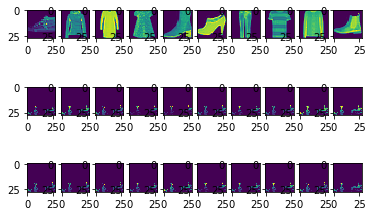

In [30]:
LATENT_DIM = 2
BATCH_SIZE = 32
EPOCHS = 15
L_IND = -6

def load_dataset():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    # Scale the image pixel value range to [-1,1], which is better than [0,1]
    X_train = np.float32((X_train-127.5)/127.5)
    X_test = np.float32((X_test-127.5)/127.5)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    X_train = np.expand_dims(X_train, -1).astype("float32")
    X_test = np.expand_dims(X_test, -1).astype("float32")
    return X_train, y_train, X_test, y_test


if __name__ == '__main__':
    X_train, _, X_test, _ = load_dataset()
    vae_model = VAE(X_train[0].shape, intermediate_dim=728, latent_dim=LATENT_DIM)
    vae, vae_encoder, vae_decoder = vae_model.vae, vae_model.encoder, vae_model.decoder
    discriminator = discriminator_model(X_train[0].shape)

    vaegan = VAEGAN(in_shape=X_train[0].shape,
                    z_shape=LATENT_DIM,
                    encoder=vae_encoder,
                    decoder=vae_decoder,
                    discriminator=discriminator,
                    inter_layer_ind=L_IND)
    
    result_encoder, result_decoder, result_discriminator = vaegan.train(train_x=X_train, 
                                                                        real_x=X_train, 
                                                                        batch_size=BATCH_SIZE,
                                                                        epochs=EPOCHS)

The first row is the original images. The second row is the reconstructed images. The third row is 10 randomly generated images.